In [386]:
from math import sqrt
import numpy as np
from numpy import concatenate
from numpy import transpose
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import initializers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import LSTM
from keras.layers import Dropout, Softmax
from keras.optimizers import RMSprop, SGD
from joblib import dump, load

In [387]:
seed_value= 1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

In [388]:
# Get same result every time
#np.random.seed(10)
#tf.random.set_seed(10)

In [389]:
dataset = pd.read_csv('energydata_complete.csv', header = 0, sep=',', quotechar='"', engine='python', usecols=[0, 1], 
                           dtype = {"date" : "datetime64[ns]", "Appliances" : "float"})

In [390]:
dataset

,date,Appliances
0,2016-01-11 17:00:00,60.0
1,2016-01-11 17:10:00,60.0
2,2016-01-11 17:20:00,50.0
3,2016-01-11 17:30:00,50.0
4,2016-01-11 17:40:00,60.0
...,...,...
19730,2016-05-27 17:20:00,100.0
19731,2016-05-27 17:30:00,90.0
19732,2016-05-27 17:40:00,270.0
19733,2016-05-27 17:50:00,420.0


In [391]:
#datetime format
dataset.index = pd.to_datetime(dataset['date'], format='%Y-%m-%d %H:%M:%S')
dataset = dataset.set_index('date')

In [392]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [393]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train1, test1 = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# make portion of validation set
actual_train_size = int(len(train1) * 0.80)
val_size = len(train1) - actual_train_size
train1, val1 = train1[0:actual_train_size,:], train1[actual_train_size:len(train1),:]

def onestep_split(dataset,k=1):
    X, Y = [], []
    for i in range(len(dataset)-k-1): #(n -(k+1)) k=1
        a = dataset[i:(i+k), 0]
        X.append(a)
        Y.append(dataset[i + k, 0])
    return np.array(X), np.array(Y)
   

X_train, Y_train = onestep_split(train1, 1)
X_val, Y_val = onestep_split(val1, 1)
X_test, Y_test = onestep_split(test1, 1)

In [394]:
X_train

array([[0.04672897],
       [0.04672897],
       [0.03738318],
       ...,
       [0.06542056],
       [0.03738318],
       [0.07476636]])

In [395]:
X_val

array([[0.09345794],
       [0.08411215],
       [0.09345794],
       ...,
       [0.06542056],
       [0.06542056],
       [0.03738318]])

In [396]:
print(X_train.shape)

(12628, 1)


In [397]:
# the net needs to get the current time step and the actual value --> shape[1], shape[2]
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)

(12628, 1, 1)


In [357]:
model = keras.Sequential()
model.add(keras.layers.LSTM(1, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64,activation='relu', bias_initializer='zeros'))
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1)                 12        
                                                                 
 batch_normalization_20 (Bat  (None, 1)                4         
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 64)                128       
                                                                 
Total params: 144
Trainable params: 142
Non-trainable params: 2
_________________________________________________________________
None


In [358]:
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.1)
model.compile(
    loss='mean_absolute_error',
    optimizer=sgd
)

In [359]:
h = model.fit(X_train, Y_train, batch_size=64, validation_data=(X_val,Y_val), epochs=20)

Epoch 1/20


2023-05-02 14:49:01.069539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-02 14:49:01.201640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 10/198 [>.............................] - ETA: 2s - loss: 0.0602 

2023-05-02 14:49:01.340475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - ETA: 0s - loss: 0.0674

2023-05-02 14:49:03.164036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-02 14:49:03.218642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - 3s 11ms/step - loss: 0.0674 - val_loss: 0.0705
Epoch 2/20
198/198 [==============================] - 2s 9ms/step - loss: 0.0616 - val_loss: 0.0606
Epoch 3/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0565 - val_loss: 0.0529
Epoch 4/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0533 - val_loss: 0.0486
Epoch 5/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0519 - val_loss: 0.0468
Epoch 6/20
198/198 [==============================] - 2s 9ms/step - loss: 0.0508 - val_loss: 0.0454
Epoch 7/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0502 - val_loss: 0.0448
Epoch 8/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0498 - val_loss: 0.0442
Epoch 9/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0494 - val_loss: 0.0437
Epoch 10/20
198/198 [==============================] - 2s 8ms/step - loss: 0.0491 - val_loss: 0.0432
Epoch 11/

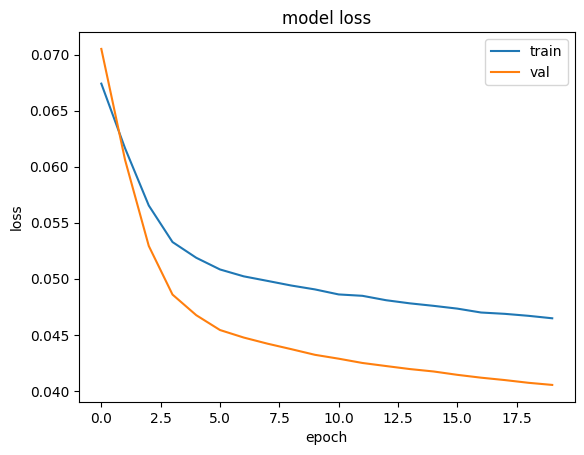

In [361]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [362]:
# Model assesment
test_predict = model.predict(X_test)

 11/124 [=>............................] - ETA: 0s 

2023-05-02 15:03:59.527678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-02 15:03:59.599391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 1s 5ms/step


In [363]:
test_predict

array([[0.16162112, 0.080387  , 0.        , ..., 0.        , 0.00948186,
        0.        ],
       [0.21339265, 0.09557662, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14637923, 0.07591507, 0.        , ..., 0.        , 0.01431575,
        0.        ],
       ...,
       [0.06362815, 0.05163611, 0.        , ..., 0.00631693, 0.04055985,
        0.02476727],
       [0.05927416, 0.05035866, 0.        , ..., 0.01394905, 0.0419407 ,
        0.02899262],
       [0.12980963, 0.07105359, 0.        , ..., 0.        , 0.01957072,
        0.        ]], dtype=float32)

In [364]:
# back to original format
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [365]:
Y_test

array([[590., 320., 310., ...,  90., 270., 420.]])

# RMSE

In [366]:
print(np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

72.89758571753664


In [367]:
# save model
#model.save('mylstm')

In [368]:
#lstm1 = keras.models.load_model('mylstm')

# Clockwork RNN

In [382]:
from keras.models import Sequential
from cwrnn import ClockworkRNN

In [383]:
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.01)
model = Sequential()
model.add(ClockworkRNN(periods=[10, 32, 64, 128],
                       units_per_period=8, 
                       input_shape=(X_train.shape[1], X_train.shape[2]), 
                       output_units=1))
model.compile(optimizer=sgd, loss='mse')
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clockwork_simple_rnn_4 (Clo  (None, 1)                737       
 ckworkSimpleRNN)                                                
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [384]:
cwrnn = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=20)

Epoch 1/20


2023-05-02 15:18:36.850768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


395/395 [==============================] - ETA: 0s - loss: 0.0086

2023-05-02 15:18:52.219519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


395/395 [==============================] - 18s 41ms/step - loss: 0.0086 - val_loss: 0.0058
Epoch 2/20
395/395 [==============================] - 15s 38ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 3/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 4/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 5/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 6/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 7/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 8/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 9/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 10/20
395/395 [==============================] - 15s 37ms/step - loss: 0.0042 - val_los

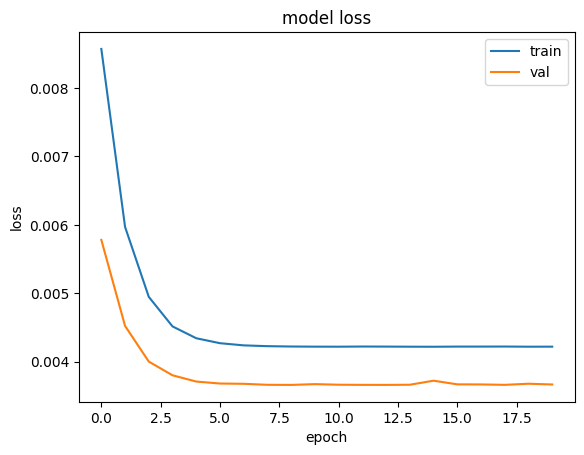

In [385]:
plt.plot(cwrnn.history['loss'])
plt.plot(cwrnn.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [398]:
# re-exhecute the preprocessing part first

# Model assesment
test_predict = model.predict(X_test)

2023-05-02 15:24:44.460051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 2s 16ms/step


In [399]:
# back to original format
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [400]:
print(np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

61.774914546708125


In [ ]:
# save model
#model.save('mycwrnn')